In [1]:
import numpy as np
import pandas as pd
import pygad
import matplotlib.pyplot as plt

In [2]:
# FUNCTION TO READ THE DATA
import json

def parse(path):
    with open(path) as f:
        data = json.load(f)
        preferences = np.array(data["preferences"])
        friendships = np.array(data["friendships"])
        authorship = np.array(data["authorship"])

        # giving the info as a dictionary
        return {
            "num_papers": data["num_papers"],
            "num_reviewers": data["num_reviewers"],
            "reviewer_capacity": data["reviewer_capacity"],
            "min_reviews_per_paper": data["min_reviews_per_paper"],
            "max_reviews_per_paper": data["max_reviews_per_paper"],
            "preferences": preferences,
            "friendships": friendships,
            "authorship": authorship
        }
#reading the data        
data = parse("medium_dataset_1.json")

#saving the data in variables
num_papers = data["num_papers"]
num_reviewers = data["num_reviewers"]
reviewer_capacity = data["reviewer_capacity"]
min_reviews_per_paper = data["min_reviews_per_paper"]
max_reviews_per_paper = data["max_reviews_per_paper"],
preferences = data["preferences"]
friendships = data["friendships"]
authorship = data["authorship"] 

preferences

array([[4, 5, 5, 1, 2, 2, 2, 1, 5, 4],
       [2, 5, 5, 5, 1, 3, 2, 4, 5, 4],
       [2, 1, 4, 2, 5, 1, 3, 3, 5, 1],
       [2, 4, 3, 1, 5, 2, 3, 2, 1, 1],
       [2, 1, 4, 3, 3, 1, 3, 3, 5, 3],
       [0, 2, 4, 2, 3, 3, 5, 5, 5, 4],
       [5, 1, 3, 2, 3, 0, 1, 0, 5, 4]])

# Fitness function

In [3]:
# parameters of the genetic algorithm
number_of_generations = 40
num_parents_mating = 5
sol_per_pop = 10
generation_size = 10

In [4]:
# representation of the solutions
representation_solutions = np.empty([number_of_generations, generation_size , num_reviewers, num_papers])

In [ ]:
# fittness function

# gene_type of GA has to be a matrix with only 0 and 1

def fitness_function(ga_instance, solution, solution_idx):
    solution_matrix = solution.reshape((num_reviewers, num_papers))
    return compute_preference_value(solution_matrix) - compute_penalty(solution_matrix)

def compute_preference_value(solution):
    pref_val = 0

    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer, paper] == 1:
                pref_val = pref_val + preferences[reviewer, paper]

    return pref_val

def compute_penalty(solution):

    penalty = 0

    # penalty for reviewer capacity
    for reviewer in range(solution.shape[0]):
        if np.sum(solution[reviewer, :]) > reviewer_capacity:
            penalty += 1 #low weight for capacity violations

    #penalty for the number of reviews in a paper
    for paper in range(solution.shape[1]):
        if np.sum(solution[:, paper]) > min_reviews_per_paper:
            penalty += 2 #moderate weight for not meeting minimum reviews
        elif np.sum(solution[:, paper]) > max_reviews_per_paper:
            penalty += 2 #moderate weight for not meeting minimum reviews

    #penalty for friendship using matricial operations
    for reviewer1 in range(solution.shape[0]):
        for reviewer2 in range(solution.shape[0]):
            if friendships[reviewer1,reviewer2] == 1: #they are friends
                for paper in range(solution.shape[1]):
                    if (solution[reviewer1,paper] == 1) and (solution[reviewer2,paper] == 1): #check if they review the same paper
                        penalty += 5 #high weight for friendship conflicts 

    #penalty for authory
    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer,paper] == 1 and (authorship[reviewer, paper]==1):
                penalty += 10 #highest weight for authorship conflicts

    return penalty

In [6]:
#try the function
solution = np.random.randint(2, size=(num_reviewers, num_papers))

print("Solution:")
print(solution)
print("Penalty: ",compute_penalty(solution))

Solution:
[[0 1 0 0 0 0 0 1 1 1]
 [0 1 0 1 0 1 0 0 0 1]
 [0 0 1 0 1 1 1 1 1 1]
 [1 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 1 1 1 1 0 0]
 [1 0 0 1 1 0 0 0 0 0]
 [1 1 0 1 1 1 1 0 1 0]]
Penalty:  250


In [ ]:
#First GA
ga_instance_1 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1], #matrix with 0 and 1
                       sol_per_pop = sol_per_pop
                       )
ga_instance_1.run()

solution, solution_fitness,  solution_idx = ga_instance_1.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[0. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1. 0. 1. 1.]]
Best fitness:  47


c:\Users\Usuario\anaconda3\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


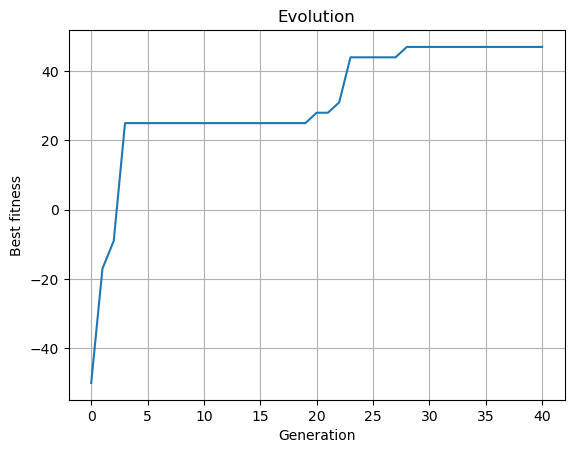

In [8]:
# Obtain the best fitness per generation
fitness_per_generation = ga_instance_1.best_solutions_fitness

plt.plot(fitness_per_generation)
plt.title("Evolution")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()

# Crossover and mutation function

In [ ]:
#Crossover funtion
def custom_crossover(parents, child_size, ga_instance):
        
    # finding random parents
    parent_idx1 = np.random.randint(1,parents.shape[1]-1)
    parent_idx2 = np.random.randint(1,parents.shape[1]-1)

    while(parent_idx1 == parent_idx2):
        parent_idx1 = np.random.randint(1,parents.shape[1]-1)
        parent_idx2 = np.random.randint(1,parents.shape[1]-1)

    parent1 = parents[parent_idx1]
    parent2 = parents[parent_idx2]
    potparents = [parent1, parent2]

    # crossing parents
    child = np.empty(child_size)
    for i in range(child_size):
        parentidx = np.random.randint(0, 2)
        parent = potparents[parentidx]
        otherParent = potparents[(parentidx - 1) % 2]

        if check_colum(parent[i]):
            child[i] = extend_child_valid(child, parent[i])
        elif check_colum(otherParent):
            child[i] = extend_child_valid(child, otherParent[i])
        else:
            # add no restictions if no parents match
            child[i] = np.zeros(child_size)
            print("no partens matched")


def check_colum(colum, index):
    # check rev per paper
    if max_reviews_per_paper < np.sum(colum) < min_reviews_per_paper:
        return False
    
    # check authorship
    for i in colum:
        if colum[i] == 1:
            if authorship[i, index] == 1:
                return False
            
    # check friendships
    for i in range(colum):
        for j in range(colum):
            if i != j:
                if colum[i] == 1 and colum[j] == 1:
                    if friendships[i, j] == 1:
                        return False
    
    return True


def extend_child_valid(child, extend):

    # reviewer_capacity has to be considered
    current_rev_max = np.max(child.sum(axis=1))
    current_rev_idx = child.sum(axis=1).argmax()
    if check_colum(extend) and current_rev_max + extend[current_rev_idx] < reviewer_capacity:
        np.stack((child, extend), axis=-1)
    else:
        # add no restictions if no parents match
        np.stack((child,  np.zeros_like(extend)), axis=-1)
        print("no partens matched")

    return child

In [10]:
#GA with custom crossover
ga_instance_2 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type = custom_crossover
                       )
ga_instance_2.run()

solution, solution_fitness,  solution_idx = ga_instance_2.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 1. 1. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0. 0. 0. 1. 1.]]
Best fitness:  64


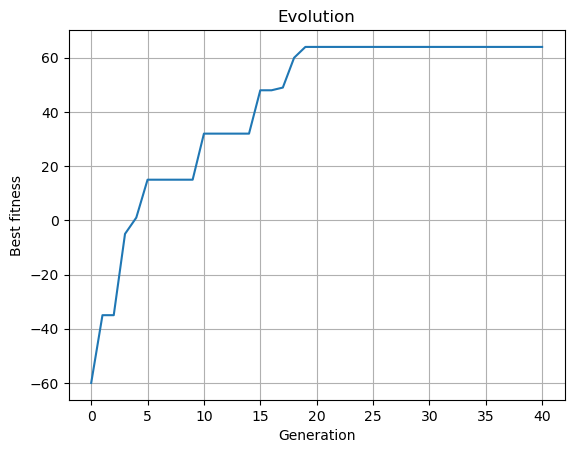

In [ ]:
# Obtain the best fitness per generation
fitness_per_generation = ga_instance_2.best_solutions_fitness

plt.plot(fitness_per_generation)
plt.title("Evolution")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()

In [12]:
def custom_mutation(solution, ga_instance):
    custom_rate = 0.1
    
    for i in range(len(solution)):
        for j in range(len(solution[i])):
            if np.random.rand() < custom_rate:          
                solution_fitness = fitness_function(ga_instance, solution[i],0)

                solution[i][j] = 1 - solution[i][j]
                muted_solution_fitness = fitness_function(ga_instance, solution[i],0)

                if muted_solution_fitness < solution_fitness:
                    solution[i][j] = 1 - solution[i][j]
    return solution


In [13]:
#GA with custom mutation
ga_instance_3 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation                     
                    )
ga_instance_3.run()

solution, solution_fitness,  solution_idx = ga_instance_3.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 1. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 0.]]
Best fitness:  97


In [14]:
#GA with custom crossover and mutation
ga_instance_4 = pygad.GA(fitness_func = fitness_function,
                       num_generations = number_of_generations,
                       num_parents_mating = num_parents_mating,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = sol_per_pop,
                       crossover_type=custom_crossover,
                       mutation_type=custom_mutation                     
                    )
ga_instance_4.run()

solution, solution_fitness,  solution_idx = ga_instance_4.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 0. 1. 1.]]
Best fitness:  102


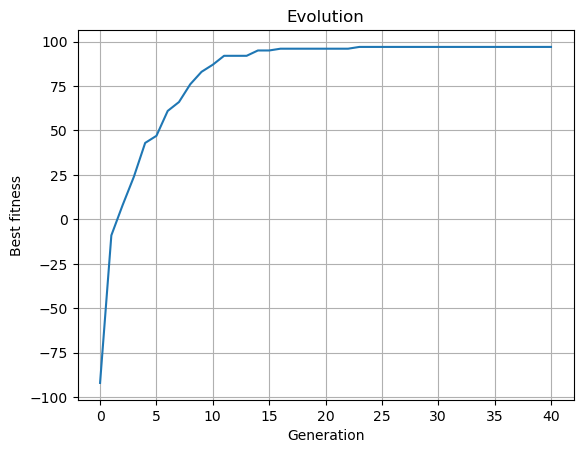

In [15]:
# Obtain the best fitness per generation
fitness_per_generation = ga_instance_3.best_solutions_fitness

plt.plot(fitness_per_generation)
plt.title("Evolution")
plt.xlabel("Generation")
plt.ylabel("Best fitness")
plt.grid()
plt.show()

# Different configurations

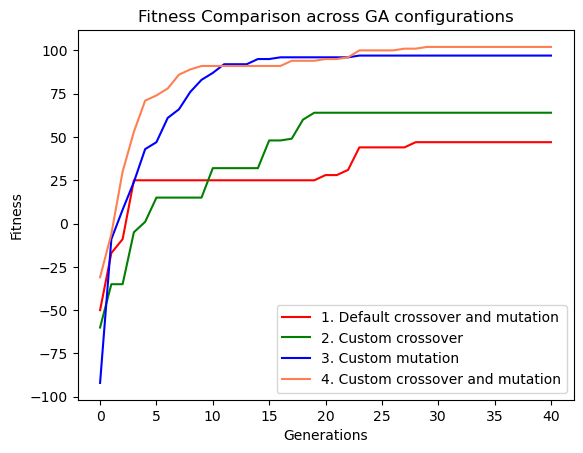

In [16]:
#Fitness evolution
results = np.array([ga_instance_1.best_solutions_fitness,
                    ga_instance_2.best_solutions_fitness,
                    ga_instance_3.best_solutions_fitness,
                    ga_instance_4.best_solutions_fitness])

titles = ["1. Default crossover and mutation",
          "2. Custom crossover",
          "3. Custom mutation",
          "4. Custom crossover and mutation"]

plt.plot(results[0],color='r',label=titles[0])
plt.plot(results[1],color='g',label=titles[1])
plt.plot(results[2],color='b',label=titles[2])
plt.plot(results[3],color='coral',label=titles[3])
plt.legend()
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.title("Fitness Comparison across GA configurations")


plt.show()


The graph illustrates the fitness evolution of different configurations of a Genetic Algorithm (GA). The fixed carachteristics are:

Number of generations = 40  
Number of parents mating = 5  
Solution per population = 10  
Generation size = 10

What varies between configurations are the crossover and the mutation function. Based on the fitness, the graph clearly shows that the combination of custom crossover and mutation (orange line) is the most effective configuration for this problem.



In [17]:
# parameters of the genetic algorithm
generation_size = 10
number_of_generations = 10

# representation of the solutions
representation_solutions = np.empty([number_of_generations, generation_size , num_reviewers, num_papers])

In [18]:
# fittness function

# TODO gene_type of GA has to be a matrix with only 0 and 1

def fitness_function(ga_instance, solution, solution_idx):
    solution_matrix = solution.reshape((num_reviewers, num_papers))
    return compute_preference_value(solution_matrix) - compute_penalty(solution_matrix)

def compute_preference_value(solution):
    pref_val = 0

    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer, paper] == 1:
                pref_val = pref_val + preferences[reviewer, paper]

    return pref_val

def compute_penalty(solution):

    penalty = 0

    # penalty for reviewer capacity
    for reviewer in range(solution.shape[0]):
        if np.sum(solution[reviewer, :]) > reviewer_capacity:
            penalty += 1

    #penalty for the number of reviews in a paper
    for paper in range(solution.shape[1]):
        if np.sum(solution[:, paper]) > min_reviews_per_paper:
            penalty += 1
        elif np.sum(solution[:, paper]) > max_reviews_per_paper:
            penalty += 1

    #penalty for friendship using matricial operations
    for reviewer1 in range(solution.shape[0]):
        for reviewer2 in range(solution.shape[0]):
            if friendships[reviewer1,reviewer2] == 1: #they are friends
                for paper in range(solution.shape[1]):
                    if (solution[reviewer1,paper] == 1) and (solution[reviewer2,paper] == 1): #check if they review the same paper
                        penalty += 5

    #penalty for authory
    for reviewer in range(solution.shape[0]):
        for paper in range(solution.shape[1]):
            if solution[reviewer,paper] == 1 and (authorship[reviewer, paper]==1):
                penalty += 5

    return penalty

In [19]:
#try the function
solution = np.random.randint(2, size=(num_reviewers, num_papers))

print("Solution:")
print(solution)
print("Penalty: ",compute_penalty(solution))

Solution:
[[1 0 0 1 1 1 1 1 0 0]
 [0 1 0 1 1 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 1 1]
 [0 1 1 0 0 0 1 1 0 0]
 [0 1 1 0 1 1 0 1 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 0 1 0 0 1 0 0 1 0]]
Penalty:  153


In [20]:
#First GA
ga_instance = pygad.GA(fitness_func = fitness_function,
                       num_generations = 50,
                       num_parents_mating = 5,
                       num_genes = num_reviewers * num_papers,
                       gene_space = [0,1],
                       sol_per_pop = 10
                       )
ga_instance.run()

solution, solution_fitness,  solution_idx = ga_instance.best_solution()
solution_matrix = solution.reshape((num_reviewers, num_papers))
print("Best solution: ")
print(solution_matrix)
print("Best fitness: ", solution_fitness)

Best solution: 
[[1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0. 1. 0.]]
Best fitness:  60


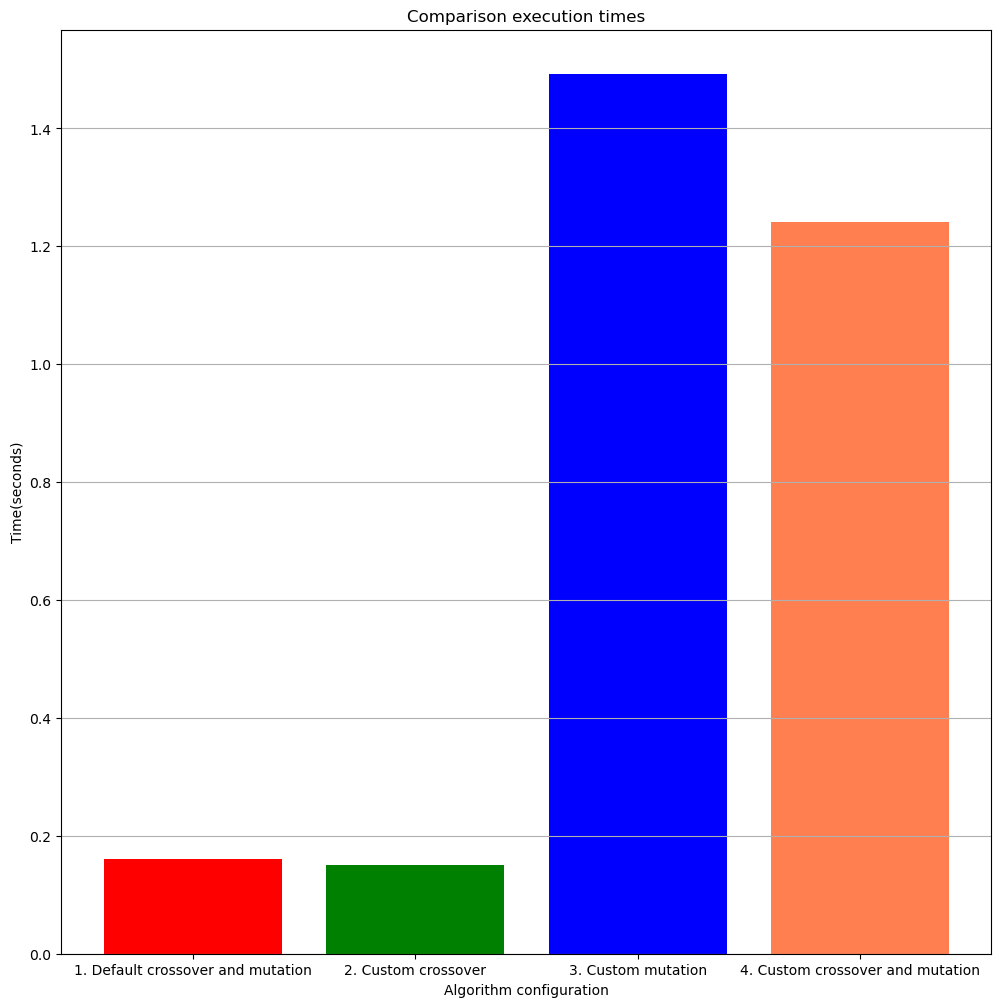

In [21]:
# execution time
import time

execution_times = []
for config in [ga_instance_1, ga_instance_2, ga_instance_3, ga_instance_4]:
    start_time = time.time()
    config.run()
    execution_times.append(time.time()-start_time)

plt.figure(figsize=(12,12))
plt.bar(titles, execution_times, color=["r","g","b","coral"])
plt.title("Comparison execution times")
plt.xlabel("Algorithm configuration")
plt.ylabel("Time(seconds)")
plt.grid(axis="y")


plt.show()